In [23]:
#あるブログをスクレイピングし、ブログ記事本文を用いてクラスタリングをしたうえで、結果について自由に考察するためのコードです。
#スクレイピングをするURLを取り除いているため、このコードはerrorが出ます。

import requests
import time
from bs4 import BeautifulSoup
import pandas as pd
import re
import MeCab
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from selenium.common.exceptions import WebDriverException
from scipy.linalg import get_blas_funcs
from scipy.linalg.lapack import get_lapack_funcs
from scipy.special import psi  
try:
    from numpy import triu
except ImportError:
    from scipy.linalg import triu
from numpy import triu
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA


# Download necessary NLTK data
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')



#Tech　ブログを全て入手するための1ページ目のウェブサイト
#base_url = ""


def get_all_pages(url):
    """
    ページ番号を取得する関数
    Args:
    - url (str): 取得するページのURL。
    
    Returns:
    - list: ページ番号のリスト。
    """
    r = requests.get(url)
    time.sleep(3) # サーバーに負荷をかけないためのスリープ
    soup = BeautifulSoup(r.text, "html.parser")
    page_na = soup.find(class_="wp-pagenavi")
    
    pages = []
    if page_na:
        # 現在のページ番号を取得
        current_page_elem = page_na.find(class_="current")
        if current_page_elem:
            pages.append(int(current_page_elem.text))
        
        # すべてのページ番号を取得
        page_num_elems = page_na.find_all(class_="page")
        for page_elem in page_num_elems:
            if page_elem.text.isdigit():
                pages.append(int(page_elem.text))
        
        # 重複を削除し、ページ番号をソート
        pages = sorted(set(pages))
    else:
        print("Pagination element not found")
    
    return pages

# すべてのページを取得
pages = get_all_pages(base_url)

# 記事のURLを保存するリスト
urls = []

# ページが見つからなかった場合、最初のページのURLを追加
if not pages:
    urls.append(base_url)
else:
    last_page = int(pages[-1])  # 最後のページ番号を取得   
    urls.append(base_url) # 最初のページのURLを追加   

    # 2ページ目以降のURLを追加
    for i in range(2, last_page + 1):
        #url = "{}".format(i)
        urls.append(url)

#デバグ用
print("URLs to be scraped:")
print(urls)


def scrape_and_save(urls):
    """
    URLリストから必要な情報をスクレイピングする関数

    Args:
    - urls (list): スクレイピング対象のURLリスト
    - output_file (str): CSVファイルの出力先パス

    Returns:
    - None
    """
    # 正規表現パターンを定義
    #pattern = re.compile(r"*")

    # URLデータとブログタイトルのデータを保存するリストを初期化
    url_list = []
    title_list = []

    # 各ページから必要な情報をスクレイピング
    for url in urls:
        response = requests.get(url)
        time.sleep(3)  # リクエスト間に3秒の待機時間を挿入
        soup = BeautifulSoup(response.text, "html.parser")

        # href属性を持つすべての<a>タグを探す
        links = soup.find_all("a", href=True)

        # URLとタイトルを抽出
        for link in links:
            href = link["href"]
            # URLがtechブログのパターンに一致するかチェック
            if pattern.match(href):
                # タイトルを抽出
                title_elem = link.find("p", class_="c-news-title")
                if title_elem is not None:
                    title = title_elem.text.strip()
                    url_list.append(href)
                    title_list.append(title)

    # 収集したデータからDataFrameを作成
    df_links = pd.DataFrame({"Title": title_list, "URL": url_list})

    return df_links,title_list, url_list


# スクレイピングしてDataFrameを取得
df_links,title_list, url_list = scrape_and_save(urls)
print(df_links)
# 処理するURLのリスト
urls = url_list

# 取り出したい品詞
select_conditions = ['名詞']

#MeCabのタグオブジェクトを生成
tagger = MeCab.Tagger('')

# MeCabのparseメソッドを一度実行して安定させる
tagger.parse('')

def wakati_text(text):
    """
    日本語の名詞と形容詞を抽出する関数
    Args:
    - text (str): 分析するテキスト
    
    Returns:
    - list: 抽出された単語のリスト
    """
    tagger = MeCab.Tagger('')  # MeCabのタグオブジェクトを生成
    tagger.parse('')  # 初期化のためにparseメソッドを一度実行
    node = tagger.parseToNode(text)  # テキストを解析してノードのリストを取得
    terms = []
    while node:
        term = node.surface  # ノードの表層形を取得
        pos = node.feature.split(',')[0]  # ノードの品詞情報を取得
        if pos in select_conditions:  # 品詞が指定した条件に一致する場合
            terms.append(term)  # リストに単語を追加
        node = node.next  # 次のノードに移動
    return terms

def extract_nouns(text):
    """
    英語の名詞を抽出する関数
    Args:
    - text (str): 分析するテキスト
    
    Returns:
    - list: 抽出された名詞のリスト
    """
    words = word_tokenize(text)  # テキストを単語に分割
    pos_tags = nltk.pos_tag(words)  # 単語に品詞タグを付与
    nouns = [word for word, pos in pos_tags if pos in ['NN', 'NNS', 'NNP', 'NNPS']]  # 名詞に該当する単語を抽出
    return nouns


def stopwords(words, lang):
    """
    指定された言語に基づいて、リスト内の不要な単語をフィルタリングする関数
    Args:
    - words (list): フィルタリングする単語のリスト。
    - lang (str): 言語コード（'jp' は日本語、'en' は英語）。

    Returns:
    - list: フィルタリングされた単語のリスト。
    """
    # 正規表現パターン：不要な単語をフィルタリングするためのパターン
    numb = r"[0-9０-９]+$"           # 数字のみのパターン
    english = r"^[a-zA-Z]$"          # 英字のみのパターン
    pair = r"^[ぁ-んァ-ン]{2}$"      # 2文字のみのパターン
    pair_english = r"^[a-zA-Z]{2}$"
    single = r"^[0-9０−９ぁ-んァ-ン一-龥!?%!-/=:@{~\u3001-\u303F]$"  # 特定の文字のみのパターン
    if lang == 'jp':
        return [x for x in words if re.match(pair, x) is None and re.match(pair_english, x) is None and re.match(single, x) is None and re.match(numb, x) is None]
    elif lang == 'en':
        return [x for x in words if re.match(pair, x) is None and re.match(single, x) is None and re.match(numb, x) is None and re.match(pair_english, x) is None and  re.match(english, x) is None]
    else:
        return []



# データフレームを格納するリスト
dfs = []

# 各URLに対して処理を行う
for i, url in enumerate(urls, 1):
    # Chromeドライバーを初期化
    service = Service(ChromeDriverManager().install())
    browser = webdriver.Chrome(service=service)
    
    browser.get(url)  # 指定されたURLをブラウザで開く
    time.sleep(3)  # ページの読み込みを待つ

    # ページソースを取得してBeautifulSoupで解析
    page_source = browser.page_source
    soup = BeautifulSoup(page_source, 'html.parser')

    # ページのテキストを取得
    text = soup.get_text()

    
    japanese_terms = wakati_text(text)  # 日本語の形容詞と名詞を抽出
    japanese_pattern = r'^[ぁ-んァ-ン一-龥]+$'#大文字英語　Allなどが出てきたためこのフィルターで英単語排除
    filtered_japanese_terms = [term for term in japanese_terms if re.match(japanese_pattern, term) is not None]
    filtered_japanese_terms = stopwords(filtered_japanese_terms, 'jp')

    # 英語の名詞を含む文を正規表現で抽出するパターン
    english_pattern = r'(?<![^\W\d_])[A-Za-z]+(?![^\W\d_])'

    
    english_term = re.findall(english_pattern, text)  # 英語の単語を正規表現で抽出

    # 英語の単語を小文字に変換　- 大文字と小文字での単語を統一するため（ex: Slackと slack）
    english_terms_lower = [x.lower() for x in english_term]

    # 英語の単語からストップワードを除外
    english_terms = stopwords(english_terms_lower, 'en')

    # 英語の単語から名詞を抽出
    pos_tags = nltk.pos_tag(english_terms_lower)
    english_noun = [word for word, pos in pos_tags if pos.startswith('NN')]
    english_terms = stopwords(english_noun, 'en')
    

    # 日本語単語が入っているリストと英語の単語が入っているリストを結合
    combined_terms = filtered_japanese_terms + english_terms
    
    # 結合された単語をストップワード関数でフィルタリング
    filtered_terms = stopwords(combined_terms, 'jp')
    
    # 単語の頻度を計算
    frequency = Counter(filtered_terms)
    
    # 最も頻度の高い上位500語を取得
    top_30_terms = frequency.most_common(500)

    # データフレームを "data_number"(各ウェブサイトを管理しやすくするためナンバリング) 列とともに作成する
    df_terms_with_data_number = pd.DataFrame({
        "Term": [term for term, _ in top_30_terms],
        "Frequency": [freq for _, freq in top_30_terms],
        "data_number": [i] * len(top_30_terms)})

    # データフレームをリストに追加する
    dfs.append(df_terms_with_data_number)
    # CSV として保存する
    file_name = "/Users/itagakikouki//dependabot_top_500_terms.csv"
    df_terms_with_data_number.to_csv(file_name, index=False)
    
    # 結果をファイルに保存する
    with open("dependabot_top_30_terms.txt", "w") as f:
        for term, freq in top_30_terms:
            f.write(f"{term}: {freq}\n")

# 全てのデータフレームを1つに結合する
result_df = pd.concat(dfs, ignore_index=True)

# CSV として保存する
result_df.to_csv("output_terms.csv", index=False)

# タイトルとURLからデータフレームを作成する
df_links = pd.DataFrame({"Title": title_list, "URL": url_list, "data_number": range(1, len(title_list) + 1)})

# data_number をキーにして dfs と df_links をマージする
result_df_with_links = result_df.merge(df_links, on="data_number", how="left")

# マージしたデータフレームを CSV ファイルに保存する
file_name = "/Users/itagakikouki//dependabot_top_30_terms_with_links.csv"
result_df_with_links.to_csv(file_name, index=False)

# CSV として保存する
result_df.to_csv("/Users/itagakikouki//dependabot_top_500_terms.csv", index=False)





URLs to be scraped:
['https://www.flywheel.jp/topics-tag/tech/', 'https://www.flywheel.jp/topics-tag/tech/page/2', 'https://www.flywheel.jp/topics-tag/tech/page/3', 'https://www.flywheel.jp/topics-tag/tech/page/4']
                                                Title  \
0                 Slack botでOpsgenieのオンコール担当者をメンションする   
1                         Dependabot アラート による脆弱性対策の分析   
2               フライウィール初の OSS “johari-mirror” を公開しました   
3                    フライウィールにおける protovalidate の導入と活用   
4    AWS Lambda で Amazon Aurora のスロークエリログを Slack 通知する   
5                             フライウィールの データスタック を紹介します   
6                                   dbt とは何をするツールなのか？   
7     フライウィールでのEngineer Team/ Business Teamのコミュニケーション   
8                                      Postmortem 読書会   
9                    渋谷オフィスへの引越し前に認証を引っ越した話 Part2-実践編   
10                       GitHub ActionsでSlackに通知を飛ばそう   
11                         企業と人材紹介会社双方の経験から考える、理想のATS   
12                        Cloud IAP で作る手軽でセキ

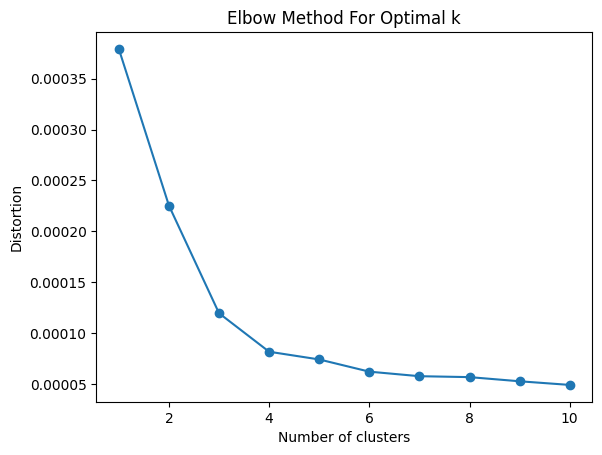

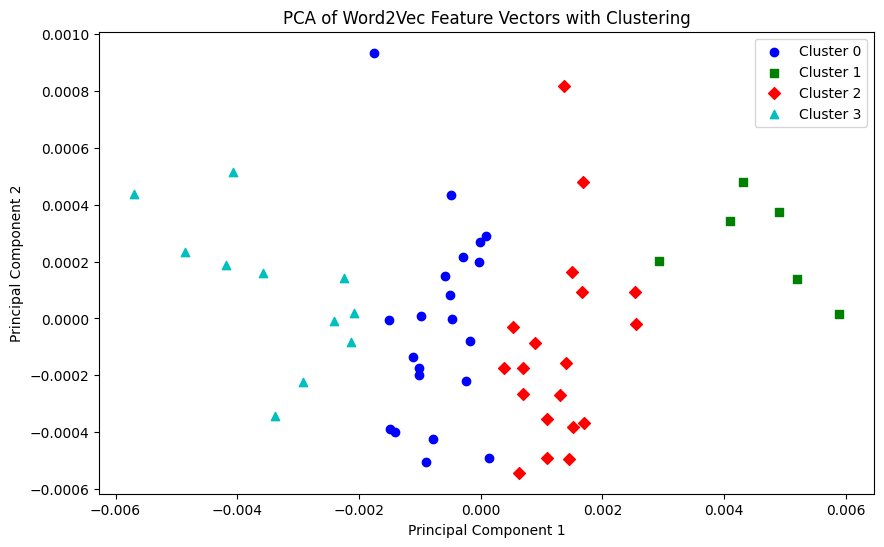

In [24]:

# 全ての文書をリストに変換
documents = []
data_numbers = []  # data_numberを保存するリスト
for i, df in enumerate(dfs):
    terms = df['Term'].tolist()
    documents.append(terms)
    data_numbers.append(i+1)  # data_numberを追加

# Word2Vecモデルの訓練
word2vec_model = Word2Vec(sentences=documents, vector_size=1000, window=5, min_count=1, workers=4)

def document_vector(model, doc):
    """
    文書の特徴ベクトルを生成する関数

    Args:
    - model: Word2Vecモデル
    - doc (list): 文書を構成する単語のリスト

    Returns:
    - numpy.ndarray: 文書の特徴ベクトル
    """
    # 各単語のベクトルを取得
    word_vectors = [model.wv[word] for word in doc if word in model.wv]
    # 単語ベクトルの平均を特徴ベクトルとする
    return np.mean(word_vectors, axis=0)

feature_vectors = []
for i in range(len(documents)):
    doc = documents[i]
    feature_vectors.append(document_vector(word2vec_model, doc))

# 特徴ベクトルをDataFrameに変換
feature_df = pd.DataFrame(feature_vectors)
feature_df['data_number'] = data_numbers  # data_number列を追加



def plot_elbow_method(feature_df, max_clusters=10):
    """
    エルボーカーブを用いてクラスタ数を決定し、グラフを描画する関数

    Args:
    - feature_df (DataFrame): クラスタリング対象の特徴量が含まれたDataFrame
    - max_clusters (int): 最大クラスタ数（デフォルトは10）

    Returns:
    - None
    """
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(feature_df.drop('data_number', axis=1))
        distortions.append(kmeans.inertia_)

    # エルボーカーブをプロット
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method For Optimal k')
    plt.show()



plot_elbow_method(feature_df)
# 最適なクラスタ数を選択
optimal_k = 4 

# クラスタリングの実行
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(feature_df.drop('data_number', axis=1))

# クラスタリング結果をDataFrameに追加
feature_df['cluster'] = kmeans.labels_

# 結果をCSVに保存
feature_df.to_csv("clustered_word2vec_feature_matrix.csv", index=False)


def plot_pca_with_clustering(feature_df, optimal_k):
    """
    PCAで特徴ベクトルを2次元に圧縮し、クラスタリング結果をプロットする関数
    
    Parameters:
    - feature_df: DataFrame, 特徴ベクトルのデータフレーム。
    - optimal_k: int, K-meansクラスタの数。
    """
    # PCAで次元削減
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(feature_df.drop(['data_number', 'cluster'], axis=1))
    
    # プロットの準備
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o', 's', 'D', '^', 'v', '>', '<']
    
    # クラスタリング結果をプロット
    plt.figure(figsize=(10, 6))
    for cluster_num in range(optimal_k):
        cluster_data = feature_df[feature_df['cluster'] == cluster_num]
        plt.scatter(pca_result[cluster_data.index, 0], pca_result[cluster_data.index, 1],
                    color=colors[cluster_num], marker=markers[cluster_num], label=f'Cluster {cluster_num}')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Word2Vec Feature Vectors with Clustering')
    plt.legend()
    plt.show()

plot_pca_with_clustering(feature_df, optimal_k)




In [25]:
new_feature_df  = feature_df[['data_number', 'cluster']]

# data_numberをキーにして結合
merged_df = new_feature_df.merge(df_links, on='data_number',how="left")

# CSVファイルを読み込む
data = pd.read_csv("/Users/itagakikouki//Google_Analytics_Page_Views.csv")


# 必要な列を選択する
selected_data = data[['event_params_page_title']]
#統合させるため列の名前の統一化
selected_data = data.rename(columns={'event_params_page_title': 'Title'})



def process_and_merge_data(selected_data, merged_df, file_name):
    """
    'Title' 列の「|」の前の部分を抽出して新しい列 'Title_prefix' を作成し、記事ごとのページビューを計算して結合する関数。
    
    Parameters:
    - selected_data: DataFrame, 処理対象のデータフレーム。
    - merged_df: DataFrame, 既存のデータフレーム。
    - file_name: str, 保存先のファイル名（CSV）。
    
    Returns:
    - mergedd_df: DataFrame, 結合後のデータフレーム。
    """
    # 'Title' 列の「|」の前の部分を抽出して新しい列 'Title_prefix' を作成
    selected_data['Title_prefix'] = selected_data['Title'].str.split('|').str[0].str.lower().str.strip()

    # 記事ごとのページビューを計算する
    page_views = selected_data.groupby('Title_prefix').size().reset_index(name='page_views')
    page_views = page_views.sort_values(by='page_views', ascending=False)

    # 既存のデータフレーム 'merged_df' も同様に 'Title' 列の「|」の前の部分を抽出して 'Title_prefix' 列を作成
    merged_df['Title_prefix'] = merged_df['Title'].str.split('|').str[0].str.lower().str.strip()

    # 'Title_prefix' をキーにして結合
    mergedd_df = merged_df.merge(page_views, on="Title_prefix", how="inner")
    print(mergedd_df)

    # CSVファイルに保存
    mergedd_df.to_csv(file_name, index=False)

    return mergedd_df

# selected_data と merged_df が既に定義されている場合
file_name = "/Users/itagakikouki//page_views.csv"
mergedd_df = process_and_merge_data(selected_data, merged_df, file_name)


'''
データセットのevent_dateによるとpage_viewが行われた最新日が2023年9月30日
data_numberが０から４のデータはそれ以降に新しく投稿されたブログな為、event_params_page_titleに表示されていない
0                   Slack botでOpsgenieのオンコール担当者をメンションする   
1                         Dependabot アラート による脆弱性対策の分析   0
2               フライウィール初の OSS “johari-mirror” を公開しました   1
3                    フライウィールにおける protovalidate の導入と活用   1
4    AWS Lambda で Amazon Aurora のスロークエリログを Slack 通知する   0
'''

# クラスターごとの総ページビューを計算
cluster_page_views = mergedd_df.groupby('cluster')['page_views'].sum().reset_index()
total_page_views = cluster_page_views['page_views'].sum()

# クラスターごとのページビューの割合を計算
cluster_page_views['percentage'] = (cluster_page_views['page_views'] / total_page_views) * 100



def plot_cluster_page_views(cluster_page_views):
    """
    クラスタごとのページビューの割合を棒グラフで表示する関数

    Args:
    - cluster_page_views (DataFrame): クラスタごとのページビュー割合が含まれるDataFrame

    Returns:
    - None
    """
    # 棒グラフを作成
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_page_views['cluster'], cluster_page_views['percentage'], color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage of Page Views')
    plt.title('Percentage of Page Views by Cluster')
    plt.xticks(cluster_page_views['cluster'], ['Cluster {}'.format(int(c)) for c in cluster_page_views['cluster']])
    plt.ylim(0, 100)

    # 割合をラベルとして表示
    for i, value in enumerate(cluster_page_views['percentage']):
        plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom')
    # グラフを表示
    plt.show()

def plot_cluster_page_views_pie(merged_df):
    """
    クラスタごとのページビューの割合を円グラフで表示する関数

    Args:
    - merged_df (DataFrame): クラスタごとのページビュー割合が含まれるDataFrame

    Returns:
    - None
    """
    # クラスターごとのページビューの割合を計算
    clusters = merged_df['cluster'].unique()
    num_clusters = len(clusters)

     # クラスタの順序に合わせてソート
    clusters.sort()

    # クラスターごとに円グラフを作成
    fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))

    for i, cluster in enumerate(clusters):
        cluster_data = merged_df[merged_df['cluster'] == cluster]
        page_view_counts = cluster_data['page_views']

        axs[i].pie(page_view_counts,autopct='%1.1f%%', startangle=90, counterclock=False)
        axs[i].set_title(f'Cluster {int(cluster)}')
        axs[i].axis('equal')

    plt.tight_layout()

    plt.show()

def plot_stacked_bar(merged_df):
    """
    クラスターごとのデータをピボットテーブルに変換し、積み上げ棒グラフを描画する関数

    Args:
    - merged_df (DataFrame): クラスターごとのデータが含まれたDataFrame

    Returns:
    - None
    """
    # クラスターごとのデータをピボットテーブルに変換
    pivot_df = merged_df.pivot_table(index='cluster', columns='Title_prefix', values='page_views', aggfunc='sum', fill_value=0)

    # クラスターごとの総ページビューを計算
    cluster_totals = pivot_df.sum(axis=1)

    # グラフを描画
    pivot_df.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')
    plt.xlabel('Cluster')
    plt.ylabel('Page Views')
    plt.title('Page Views by Cluster and Title')
    plt.legend(title='Title Prefix', bbox_to_anchor=(1.05, 1), loc='upper left')

    # フォントを日本語対応に設定
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meiryo', 'MS Gothic', 'sans-serif']

    plt.show()

/var/folders/01/2yvtxtrj6fgf56ngvy06bjpw0000gn/T/ipykernel_1340/615396499.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/itagakikouki/事前課題/Google_Analytics_Page_Views.csv")


    data_number  cluster                                              Title  \
0             6        3                            フライウィールの データスタック を紹介します   
1             7        3                                  dbt とは何をするツールなのか？   
2             8        0    フライウィールでのEngineer Team/ Business Teamのコミュニケーション   
3             9        2                                     Postmortem 読書会   
4            10        0                   渋谷オフィスへの引越し前に認証を引っ越した話 Part2-実践編   
5            11        2                       GitHub ActionsでSlackに通知を飛ばそう   
6            12        3                         企業と人材紹介会社双方の経験から考える、理想のATS   
7            13        0                        Cloud IAP で作る手軽でセキュアな社内サービス   
8            14        2                        ソフトウェアエンジニアの採用にルーブリックを導入した話   
9            15        0                非エンジニアが業務効率改善のためのSlackbot開発を引き継いでみた   
10           18        3                       ErrorProne Custom Plugin を書く   
11           19        2                     Airflow

                                                Title  page_views
1                                   dbt とは何をするツールなのか？       15405
28                                  デザインドックで学ぶデザインドック        3899
38                                  Spring WebFlux 入門        3173
11                     Airflow で異なる DAG 間の依存関係を設定する方法        3055
21                                  ビルドツール「Bazel」について        2964
39                                    FLYWHEEL って、なに？        2380
0                             フライウィールの データスタック を紹介します        2225
43                                      go links のススメ        1548
31                   Fail fast as a PM – PMは「速く失敗」しよう        1522
7                         Cloud IAP で作る手軽でセキュアな社内サービス        1121
33             Amazon CloudWatch Logs Insights を使ってみた         943
13                      とあるエンジニアがWFHしたときのとっても詳細な1日の流れ         683
34                              一行もコードを書かずにWebスクレイピング         655
8                         ソフトウェアエンジニアの採用にルーブリックを導入した話         410
2     フライウ

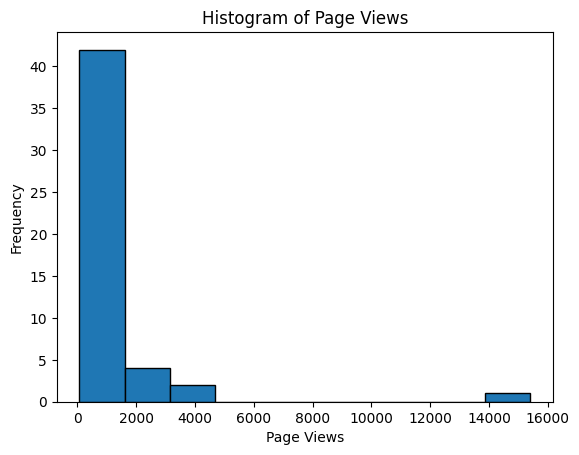

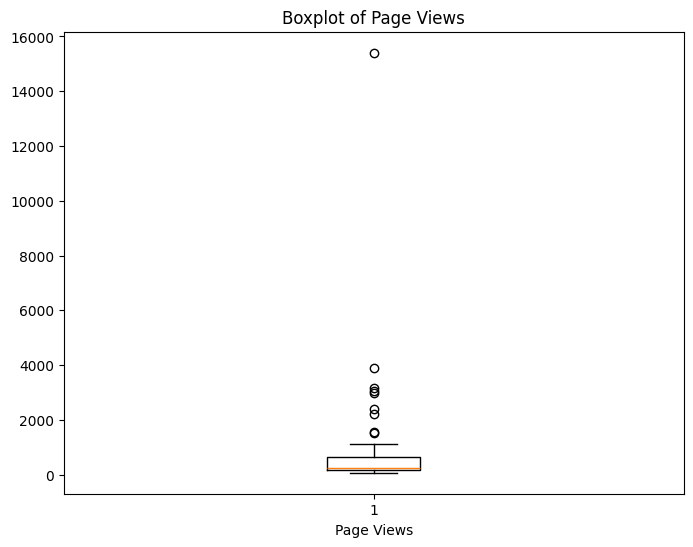

[[-4.1850791e-03  1.8711064e-04]
 [-1.0159872e-03 -1.7464120e-04]
 [-5.8416626e-04  1.4864009e-04]
 [-1.1150548e-03 -1.3525196e-04]
 [-4.8534353e-03  2.3473256e-04]
 [-3.3844586e-03 -3.4279510e-04]
 [-2.9175577e-03 -2.2390923e-04]
 [-1.9673207e-05  1.9936592e-04]
 [ 1.6588675e-03  9.4442919e-05]
 [-7.8214990e-04 -4.2423038e-04]
 [ 1.5259642e-03 -3.8317710e-04]
 [-2.0796135e-03  1.9557809e-05]
 [-9.8802114e-04  8.6315376e-06]
 [ 1.0982143e-03 -4.8990711e-04]
 [-1.4830924e-03 -3.8945855e-04]
 [-1.0213353e-03 -2.0042232e-04]
 [-2.2456709e-03  1.4308358e-04]
 [-4.0641171e-03  5.1476766e-04]
 [ 5.2717229e-04 -3.0146301e-05]
 [ 1.6926175e-03 -3.6751325e-04]
 [ 1.4083802e-03 -1.5537279e-04]
 [ 1.4189690e-04 -4.9164280e-04]
 [-8.9776318e-04 -5.0456449e-04]
 [ 1.0941854e-03 -3.5267201e-04]
 [-1.5067029e-03 -4.2563324e-06]
 [-5.1076780e-04  8.2746665e-05]
 [ 6.9061189e-04 -2.6700881e-04]
 [ 6.2767626e-04 -5.4309453e-04]
 [-2.8681842e-04  2.1785386e-04]
 [-5.6910352e-03  4.3819900e-04]
 [ 1.30464

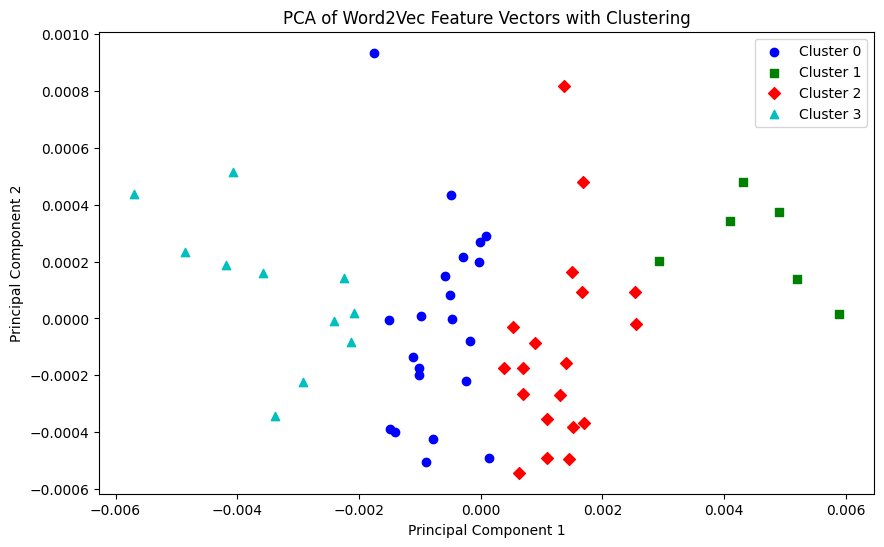

In [28]:
#外れ値を予測するためグラフの表示

#閲覧数を高い順に表示
sorted_df = mergedd_df.sort_values(by='page_views',ascending=False)[["Title","page_views"]]
print(sorted_df)

import matplotlib.pyplot as plt

def plot_page_views_histogram(df, column_name, bins=10, edgecolor='black'):
    """
    データフレーム内の指定された列のヒストグラムをプロットする関数
    
    Parameters:
    - df: DataFrame, データフレーム。
    - column_name: str, ヒストグラムを作成する列の名前。
    - bins: int, ヒストグラムのビンの数（デフォルトは10）。
    - edgecolor: str, ビンのエッジの色（デフォルトは 'black'）。
    """
    plt.hist(df[column_name], bins=bins, edgecolor=edgecolor)
    plt.xlabel('Page Views')
    plt.ylabel('Frequency')
    plt.title('Histogram of Page Views')
    plt.show()

plot_page_views_histogram(mergedd_df, "page_views")






import matplotlib.pyplot as plt

def plot_page_views_boxplot(df, column_name, figsize=(8, 6), vert=True):
    """
    データフレーム内の指定された列の箱ひげ図をプロットする関数
    
    Parameters:
    - df: DataFrame, データフレーム。
    - column_name: str, 箱ひげ図を作成する列の名前。
    - figsize: tuple, 図のサイズ（デフォルトは (8, 6)）。
    - vert: bool, 箱ひげ図の方向（デフォルトは True: 垂直）。
    """
    plt.figure(figsize=figsize)  # 図のサイズを設定
    plt.boxplot(df[column_name], vert=vert)  # vert=False で水平方向に描画
    plt.xlabel('Page Views')
    plt.title('Boxplot of Page Views')
    plt.show()

plot_page_views_boxplot(mergedd_df, "page_views")



def plot_pca_with_clustering(feature_df, optimal_k):
    """
    PCAで特徴ベクトルを2次元に圧縮し、クラスタリング結果をプロットする関数
    
    Parameters:
    - feature_df: DataFrame, 特徴ベクトルのデータフレーム。
    - optimal_k: int, K-meansクラスタの数。
    """
    # PCAで次元削減
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(feature_df.drop(['data_number', 'cluster'], axis=1))
    print(pca_result)
    
    # プロットの準備
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o', 's', 'D', '^', 'v', '>', '<']
    
    # クラスタリング結果をプロット
    plt.figure(figsize=(10, 6))
    for cluster_num in range(optimal_k):
        cluster_data = feature_df[feature_df['cluster'] == cluster_num]
        plt.scatter(pca_result[cluster_data.index, 0], pca_result[cluster_data.index, 1],
                    color=colors[cluster_num], marker=markers[cluster_num], label=f'Cluster {cluster_num}')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Word2Vec Feature Vectors with Clustering')
    plt.legend()
    plt.show()

plot_pca_with_clustering(feature_df, optimal_k)

    cluster  page_views                                              Title
35        0         104                          FLYWHEEL アドベントカレンダーを支える技術
28        0        3899                                  デザインドックで学ぶデザインドック
29        0         206                 Google Colaboratoryでニューラル協調フィルタリング
17        0         326             Kubernetes + Fluentd + CloudWatch Logs
16        0         338                                  クッキーの動作の変更とプライバシー
15        0          96                   渋谷オフィスへの引越し前に認証を引っ越した話 Part1-導入編
14        0         162                                スタートアップと大企業の違いからの学び
30        0         339                  BtoB Startup における Product Manager
31        0        1522                   Fail fast as a PM – PMは「速く失敗」しよう
20        0         133                          プログラミング練習問題で学ぶオンライン広告のしくみ
23        0         211                         Brainwriting でブログアイデアを発掘する
36        0         305                                Juliaでラマヌジャンの数式を味わう
7         0        1121  

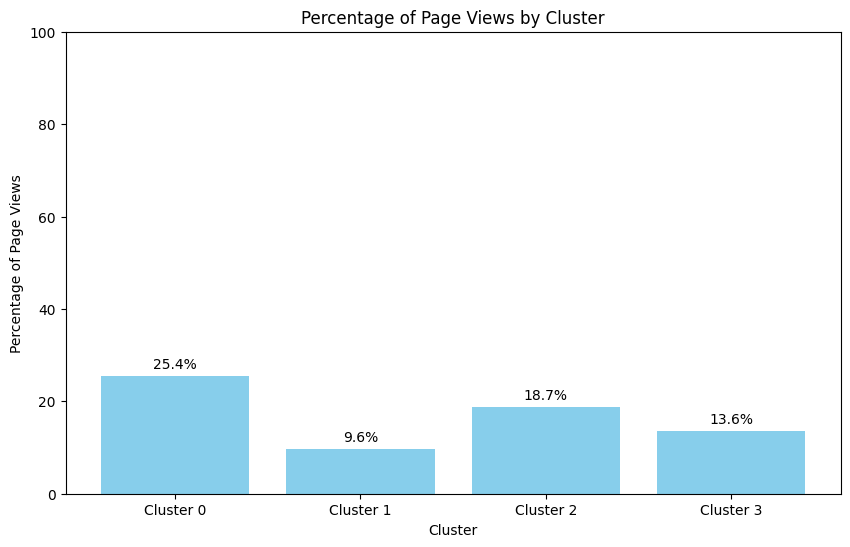

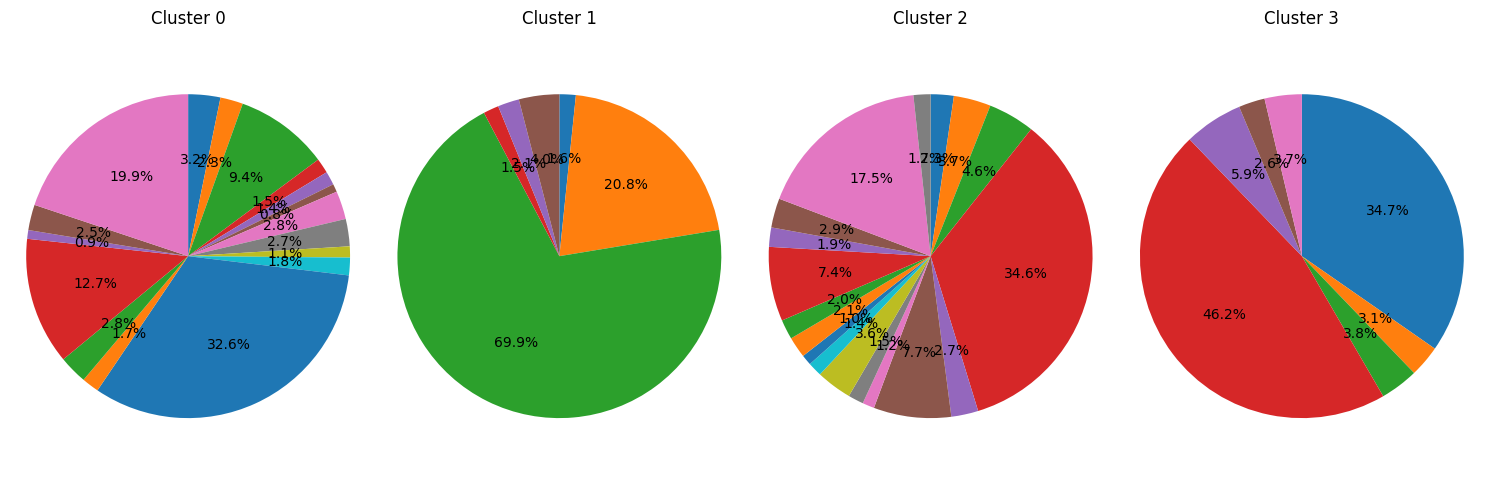

Q1: 166.5
Q3: 471.25
IQR: 304.75
Lower Bound: -290.625
Upper Bound: 928.375
This is outliers:      data_number  cluster                                   Title  \
0             6        3                 フライウィールの データスタック を紹介します   
7            13        0             Cloud IAP で作る手軽でセキュアな社内サービス   
11           19        2          Airflow で異なる DAG 間の依存関係を設定する方法   
21           30        3                       ビルドツール「Bazel」について   
28           37        0                       デザインドックで学ぶデザインドック   
31           40        0        Fail fast as a PM – PMは「速く失敗」しよう   
33           42        1  Amazon CloudWatch Logs Insights を使ってみた   
38           47        1                       Spring WebFlux 入門   
39           48        0                         FLYWHEEL って、なに？   
43           52        2                           go links のススメ   

                                                  URL  \
0          https://www.flywheel.jp/topics/data_stack/   
7   https://www.flywheel.jp/topics/interna

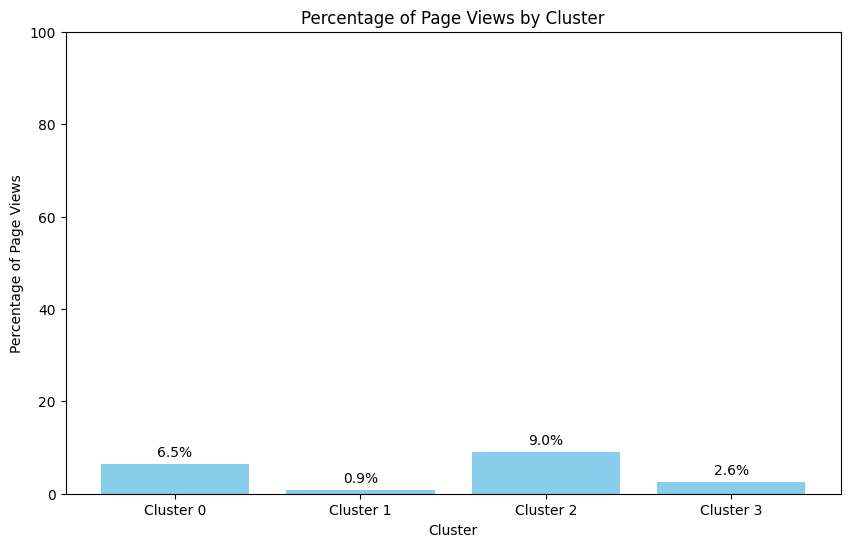

In [29]:
#外れ値をより詳しく分析

#cluster　別のタイトル取得
import matplotlib.pyplot as plt


#クラスター別のブログタイトル、閲覧数の表示
cluster_mergedd_df = mergedd_df.sort_values(by='cluster', ascending=True)
print(cluster_mergedd_df[['cluster', 'page_views','Title']])
#外れ値の削除
mergedd_df = mergedd_df[mergedd_df['Title'] != 'dbt とは何をするツールなのか？']
# 各クラスターごとに特徴量の平均値を計算
cluster_means = mergedd_df.groupby('cluster')['page_views'].mean()
print("クラスターごとの平均値：",cluster_means)
# 各クラスターごとに特徴量の中央値を計算
cluster_medians = mergedd_df.groupby('cluster')['page_views'].median()
print("クラスターごとの中央値：",cluster_medians)



cluster_mergedd_df = mergedd_df.groupby('cluster')['page_views'].sum().reset_index()
total_page_views = cluster_page_views['page_views'].sum()
cluster_mergedd_df['percentage'] = (cluster_mergedd_df['page_views'] / total_page_views) * 100


plot_cluster_page_views(cluster_mergedd_df) #棒グラフ
#pie chart
plot_cluster_page_views_pie(mergedd_df)

merged_df_sorted = mergedd_df.sort_values(by='page_views', ascending=False)




# page_views 列を取得
page_views = mergedd_df['page_views']


# 第一四分位数（Q1）、第三四分位数（Q3）を計算
Q1 = page_views.quantile(0.25)
Q3 = page_views.quantile(0.75)

# IQRを計算
IQR = Q3 - Q1

# 外れ値の基準を計算
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)


# 外れ値を抽出
outliers = mergedd_df[(page_views < lower_bound) | (page_views > upper_bound)]
print("This is outliers: ",outliers)


# 外れ値を削除
filtered_df = mergedd_df[(page_views >= lower_bound) & (page_views <= upper_bound)]

#外れ値を全て削除した場合の棒グラフの作成
cluster_filtered_df = filtered_df.groupby('cluster')['page_views'].sum().reset_index()
total_page_views = cluster_page_views['page_views'].sum()
cluster_filtered_df['percentage'] = (cluster_filtered_df['page_views'] / total_page_views) * 100
plot_cluster_page_views(cluster_filtered_df)





In [30]:
#クラスターごとに重要な単語(頻出単語)の抽出



#display_top_terms_per_cluster関数を用いるためにクラスターとTerms,閲覧数があるデータフレームの作成
dfs_combined = pd.concat(dfs, ignore_index=True)
count_frequent_words = dfs_combined.merge(new_feature_df, on="data_number", how="left")


def display_top_terms_per_cluster(data, top_n=20):
    """
    クラスターごとに同じ用語の頻度を合算し、各用語の合計頻度を取得し、上位の頻度を表示する関数
    
    Parameters:
    - data: DataFrame, 用語と頻度のデータフレーム。列名は 'cluster', 'Term', 'Frequency'。
    - top_n: int, クラスターごとに表示する上位の用語数（デフォルトは20）。
    """
    # クラスターごとに同じ用語の頻度を合算する
    summed_freq_per_cluster = data.groupby(['cluster', 'Term'])['Frequency'].sum().reset_index()

    # クラスターごとに上位の頻度を表示する
    for cluster in summed_freq_per_cluster['cluster'].unique():
        print(f"Cluster {cluster}:")
        top_terms = summed_freq_per_cluster[summed_freq_per_cluster['cluster'] == cluster].nlargest(top_n, 'Frequency')
        print(top_terms[['Term', 'Frequency']])
        print()


display_top_terms_per_cluster(count_frequent_words, top_n=20)






Cluster 0:
        Term  Frequency
1253      情報        133
1729      設定        101
1205      広告         97
723    プロダクト         86
1835      開発         83
1241      必要         80
1609      管理         76
710      ブログ         75
565    エンジニア         73
651     デザイン         68
1444      機能         66
545     アクセス         65
561   ウェブサイト         65
889       会社         64
1163      実装         64
903       使用         63
1100      場合         60
1347      文字         58
1525      環境         58
664      ドック         57

Cluster 1:
          Term  Frequency
2071        保存         31
1891     event         30
2150        情報         27
2087        処理         26
2245        設定         21
2092        分析         20
1968    ウェブサイト         18
2017       ブログ         18
2123        場合         18
1962       アプリ         17
1895  flywheel         16
1915    number         16
1944      time         16
2067        使用         16
1979      クリック         15
1964      イベント         14
2159        採用         14
1987 